<img src="./imgs/1.png">

# Машинное обучение

> Говорят, что компьтерная программа обучается решению задачи T на основе опыта E, если качество решения по метрике P растет по мере накопления опыта E. (_Mitchell "Machine learning", 1997_)

### Задача T

В машинном обучении, под этими терминам обычно подразумевают следующее:
- задача Т: это то, что мы должны сделать с **объектами (examples)**, которые обычно представленны в виде векторов **признаков (features)**

Среди наиболее популярных задач T, интересных нам в курсе, выделяют:
- **регрессию** - предсказание непрерывной переменной (_цены на недвижимость_)
- **классификацию** - предсказание класса объекта (_определение марки авто по фотографии_)
- **кластеризация** - группировка данных (_разбиение потока новостей на сюжеты_)
- **обучение с подкреплением** - обучение игре на основе опыта (_игра в Го_)

Хороший обзор многих других методов можно найти в книге _Ian Goodfellow et. al. "[Deep Learning](http://www.deeplearningbook.org/contents/ml.html)", 2016_

### Метрика, P

> То что вы не можете измерить – вы не можете улучшить

Метрика показывает насколько хорошо данный алгоритм решает поставленную задачу. В простейшем случае с классификаций, самой просто метрикой может быть просто процент ошибок.

Важно понимать, что выбор метрики напрямую влияет на решение задачи. Если метрика будет выбрана не корректно, то задача может быть плохо решена или вовсе не решена.

### Опыт, E

Все алгоритмы можно разделить на 2 большие группы:
- обучение без учителя
- обучение с учителем

В обоих случаях опыт представляется набором объектов (**dataset**). В случае обучения без учителя задача сводится к поиску некоторых закономерностей в наборе данных. Если мы говорим про обучение с учителем, то кроме самих объектов даны **метки (targets, labels)**, которые нужно научиться предсказывать.

# Лирическое отступление

В нашем курсе мы будем постоянно использовать ряд библиотек, такие как numpy, pandas, seaborn и т.д. Если вы с ними не знакомы, настоятельно рекомендуем изучить их, например [тут](https://habrahabr.ru/company/ods/blog/322626/) и [тут](https://habrahabr.ru/company/ods/blog/323210/).

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
import math
%matplotlib inline

In [30]:
# Многие примеры и алгоритмы используют генератор случайных чисел. 
# Чтобы решение было воспроизводимым не забывайте инициализировать генератор.
np.random.seed(102)

# Линейная регрессия

Рассмотрим один из простейший алгоритмов машинного обучения: __линейную регрессию__.

Нам нужно измерить коэффициент упругости пружины. Мы знаем, что растяжение пружины подчиняется закону Гука:
$$ F = k \Delta l $$

Проведя серию измерений для разных $\Delta l$ мы получаем следующую картинку:

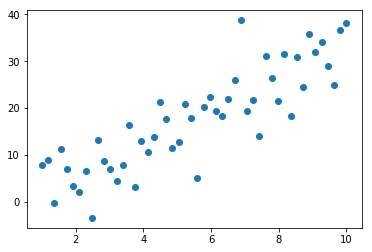

In [31]:
def measure(delta):
    return 3.14 * delta + np.random.normal(scale=5)
d = np.linspace(1,10, num=50)
f = np.vectorize(measure)(d)
plt.plot(d, f, 'o')

В задаче линейной регрессии мы предполагаем, что данные пораждаются следующим процессом:

$$ \Large y = \vec{w}^T \vec{x} + \epsilon$$

- $y$ - целевая переменная
- $\vec{w}$ - вектор параметров модели
- $\vec{x}$ -  вектор признаков объекта
- $\epsilon \sim \mathcal{N}(0,\,\sigma^{2})
$ - случайная ошибка, полученная из нормального распределения с нулевым матожиданием

На выходе из эксперимента мы имеем набор данных из $N$ объектов $\{\vec{x}_n\}$ и соответствующие им результаты измерений $\{y_n\}$. Наша задача сводится к определению коэффициентов регрессии $\vec{w}$.

# Максимизация правдоподобия (likelihood)

Для решения этой задачи нам нужно определиться с метрикой качества, которая покажет степень соответствия данной модели и тренировочных данных. Для этого воспользуемся методом максимизации правдоподобия.

Правдоподобием называют вероятность того, что данная выборка была семплирована из данного распределения. Если объекты независимы и одинаково распределённы, то правдоподобие вычисляется как:
$$
    \Large
    \mathcal {L}_\theta = \prod_{i=1}^{N} P_\theta(\vec{x}_i)
$$

Т.к. большенство распределений параметрические, правдоподобие удобно использовать для того, чтобы оценить параметры распределения из которого появилась выборка. Для этого нужно найти такое $\theta$ при котором правдоподобие будет максимальным. 

Посмотрим на нашу модель с вероятностной точки зрения.
<img src="./imgs/2.png" alt="Bishop, Pattern Recognition and Machine Learning, 2006" style="width: 500px;"/>

$$
\Large 
y = \mathbb{E}\left[ p(t|x,w,\sigma^{2}) \right]
$$

Выпишем фунцию правдоподобия для нашего набора данных. Сразу возьмем логарифм правдоподобия, т.к. он поможет нам избавиться от произведения и степени экспоненты в нормальном распределении
$$
\Large 
\begin{array}{rcl}
 \log \left(\mathcal {L}\right) 
              &=& \log \prod_{i=1}^{N} \mathcal{N}(\vec{w}^T \vec{x}_i,\,\sigma^{2}) \\
              &=& \sum_{i=1}^n \log \mathcal{N}\left( \vec{w}^T \vec{x}_i, \sigma^2 \right) \\ 
              &=& \sum_{i=1}^n \log \frac {1}{\sigma {\sqrt {2\pi}}}\;e^{-{\frac {(y_i-\vec{w}^T \vec{x}_i )^{2}}{2\sigma ^{2}}}} \\
              &=& -n \log \sigma {\sqrt {2\pi}} -\frac{1}{2\sigma^2} \sum_{i=1}^n 
                  \left(y_i - \vec{w}^T \vec{x}_i\right)^2
\end{array}
$$

Таким образом задача сводится к максимизации правдоподобия.
$$
\Large 
\begin{array}{rcl}
\hat{w} &=& \arg \max_{w} log\left(\mathcal {L}\right) \\ 
        &=& \arg \max_{w} -n \log \sigma {\sqrt {2\pi}} -\frac{1}{2\sigma^2} \sum_{i=1}^n \left(y_i - \vec{w}^T \vec{x}_i\right)^2 \\ 
        &=& \arg \max_{w} - \sum_{i=1}^n \left(y_i - \vec{w}^T \vec{x}_i\right)^2 \\ 
        &=& \arg \min_{w} L\left(X, \vec{y}, \vec{w}\right)
\end{array}
$$

# Аналитическое решение

Для того, чтобы найти веса $\vec{w}$ приравняем к нулю производную функции потерь $L$

$$
\Large 
\begin{array}{rcl} 
\frac{\partial L}{\partial \vec{w}} = 0 
    &\Leftrightarrow& \frac{1}{2n} \left(-2 X^T \vec{y} + 2X^T X \vec{w}\right) = 0 \\ 
    &\Leftrightarrow& -X^T \vec{y} + X^T X \vec{w} = 0 \\ 
    &\Leftrightarrow& X^T X \vec{w} = X^T \vec{y} \\ 
    &\Leftrightarrow& \vec{w} = \left(X^T X\right)^{-1} X^T \vec{y} 
\end{array}
$$

Недостатки аналитического решения:
- Вырожденность матрицы $X^TX$
- Вычислительная сложность обращения матрицы
- Вычислительная стабильность операции обращения

# Полиномиальная регрессия

На практике часто бывает так, что зависимость в данных имеет нелинейную природу. В таких случаях решением может быть линейная комбинация нелинейных признаков:
$$
    y = w_0 + w_1 \phi_1(\vec{x}) + w_2 \phi_2(\vec{x})
$$

В простейшем случае функцией $\phi$ может быть возведение в $i$-ю степень. Тогда мы получаем так называемую полиномиальню регрессию
$$
    y = w_0 + w_1 x^1 + w_2 x^2 + w_3 x^3 + ... + w_p x^p
$$

Давайте попробуем при помощи полиномиальной регрессии востановить функцию синуса.

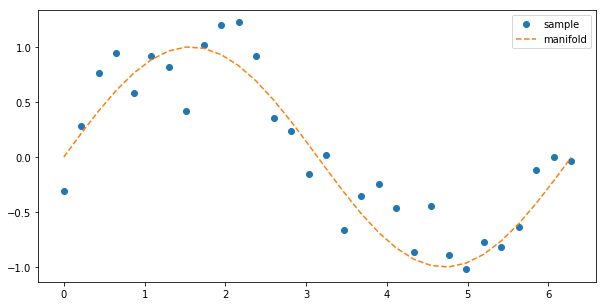

In [32]:
plt.figure(figsize=(10,5))

np.random.seed(108)
x = np.linspace(0, 2*3.14, num=30)
y = np.sin(x) + np.random.normal(0, 0.3, size=x.shape[0])
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

<class 'numpy.ndarray'>
Degree: 2, Loss: 2.7163005284864163
<class 'numpy.ndarray'>
Degree: 4, Loss: 1.3262866897365504
<class 'numpy.ndarray'>
Degree: 8, Loss: 1.0489579585661328


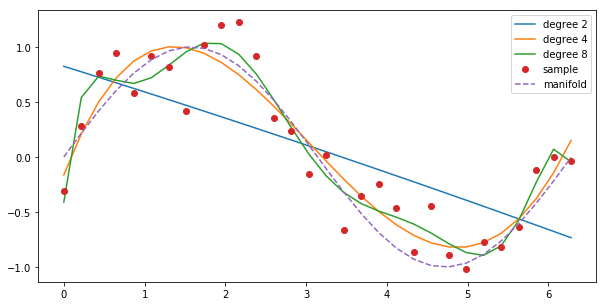

In [33]:
plt.figure(figsize=(10,5))

def power_features(x, p):
    return np.array( [np.ones(x.shape[0])] + list(map(lambda n: x**n, range(1, p + 1))) ).T

for degree in [2,4,8]:
        
    # решаем задачу
    X = power_features(x, degree)
    print(type(X))
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    # визуализируем результат
    y_hat = np.dot(w, X.T)
    plt.plot(x, y_hat, label='degree %s' % degree)
    print('Degree: %s, Loss: %s' % (degree, np.linalg.norm(y - y_hat, 2)))
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

Визуально видно, что регрессия 4й степени неплохо приближает реальную зависимость. При этом увеличение степени полинома до 8 еще больше уменьшает loss на трейне. Но визуально мы видим, что наш результат стал хуже. Данное явление называется переобучение.

Для контроля за переобучением данные случайным образом разделяют на 2 части: обучающую и тестовую выборки.

Degree: 2, train loss: 2.5254747004116664, test loss: 1.0786793694696233
Degree: 4, train loss: 1.0066662090062997, test loss: 0.9220393314632622
Degree: 8, train loss: 0.6441493382379265, test loss: 1.015852924489265


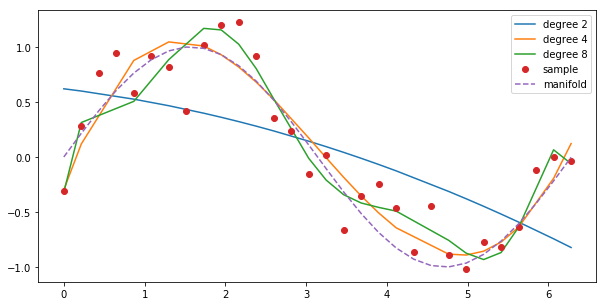

In [42]:
from sklearn.cross_validation import train_test_split

plt.figure(figsize=(10,5))

# Делим данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test \
    = train_test_split(x, y, random_state=10)
order = np.argsort(x_train)
train_loss = []
test_loss = []

for degree in [2,4,8]:
    
    # решаем задачу
    X = power_features(x_train, degree)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_train)
    # визуализируем результат
    y_hat = np.dot(w, X.T)
    X_test = power_features(x_test, degree)
    y_hat_test = np.dot(w, X_test.T)
    train_l = np.linalg.norm(y_train - y_hat)
    test_l = np.linalg.norm(y_test - y_hat_test)
    print('Degree: %s, train loss: %s, test loss: %s' % (degree, train_l , test_l ))
    plt.plot(x_train[order], y_hat[order], label='degree %s' % degree)
        
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

Обычно график ошибок на обучающем и тестовом множестве выглядят как так:
<img src="./imgs/3.png" alt="" style="width: 600px;"/>

Нужно понимать, что значение метрики это тоже случайная величина. Ее случайность определяется ограниченностью этой выборки. Более того, на практике размер тестового множества пытаются сделать как можно меньше, чтобы сберечь данные для обучения.

Для решения этой проблемы используют метод перекрестной проверки (k-fold cross validation). Для каждого значения метапараметра мы строим k моделей, используя в качестве теста разные куски исходного набора данных. Затем полученные на тесте ошибки усредняются.

<img src="./imgs/4.png" alt="" style="width: 400px;"/>

# Регуляризация

Регуляризация — это способ уменьшить сложность модели чтобы предотвратить переобучение или исправить некорректно поставленную задачу

Она достигается добавлением некоторой априорной информации к условию задачи. Для задачи линейной регресии можно ввести ограничение на значения весов модели, например, используя $L^2$ регуляризацию:
$$
    L_{reg} \left(X, \vec{y}, \vec{w}\right) =\left\| \vec{y} - X \vec{w} \right\|_2^2  + \frac{\lambda}{2} \left\| \vec{w} \right\|_2^2
$$

Аналитическое решение для задачи регрессии с $L^2$ регуляризацией будет иметь следующий вид:
$$
\vec{w} = \left(X^T X + \lambda E\right)^{-1} X^T \vec{y} 
$$

Такая регрессия называется гребневой регрессией (ridge regression) из-за гребеня в мартице $X^T X$.

<img src="./imgs/5.png" alt="" style="width: 400px;"/>

Давайте посмотрим, как ведет себя решение для p=8 и разных значений $\lambda$

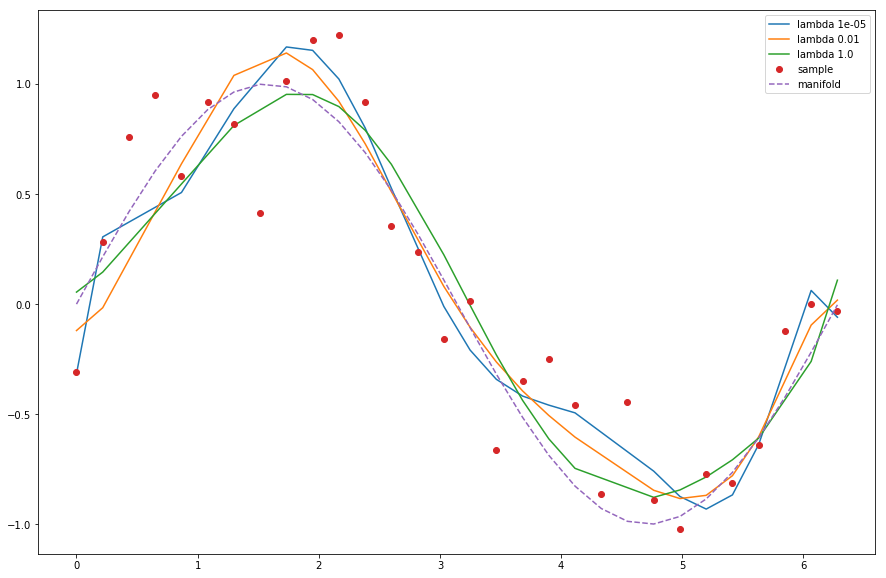

In [39]:
from sklearn.cross_validation import train_test_split

plt.figure(figsize=(15,10))

# Делим данные на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)
order = np.argsort(x_train)
train_loss = []
test_loss = []

for lmd in [0.00001, 0.01, 1.]:
    degree = 8
    # решаем задачу
    X = power_features(x_train, degree)
    w = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)+lmd*np.eye(X.shape[1])), X.T), y_train)
    
    # визуализируем результат
    y_hat = np.dot(w, X.T)
    X_test = power_features(x_test, degree)
    y_hat_test = np.dot(w, X_test.T)
    train_l = np.linalg.norm(y_train - y_hat, 2)
    test_l = np.linalg.norm(y_test - y_hat_test)

    plt.plot(x_train[order], y_hat[order], label='lambda %s' % lmd)
        
plt.plot(x, y, 'o', label='sample')
plt.plot(x, np.sin(x), '--', label='manifold')
plt.legend()

# Задача классификации

В задаче классификации каждому объекту из обучающей выборки присваивается метка +1 или -1 в зависимости от класса. При этом мы хотим научится оценивать вероятность $P_+(\vec{x})$ принадлежности объекта к классу +1. Очевидно, что линейная регрессия нам здесь не поможет.

Для решения этой задачи рассмотрим такую вещь как шанс. Шансом называют
$$
OR_+ = \frac{P_+(x)}{1 - P_+(x)}
$$

В то время как значение вероятности лежит в диапазоне $[0,1]$, значение шанса лежит в диапазоне $[0,\infty]$. А логорифм шанса лежит в диапазоне $[-\infty,+\infty]$ и может быть приближен линейной моделью
$$
ln\left(OR_+(\vec{x})\right) = \vec{w}^T \vec{x}
$$

Теперь осталось совместить два определения и получить модель для $P_+(\vec{x})$
$$
P_+(\vec{x}) = \frac{OR_{+}(\vec{x})}{1 + OR_{+}(\vec{x})} = \frac{\exp^{\vec{w}^T\vec{x}}}{1 + \exp^{\vec{w}^T\vec{x}}} = \frac{1}{1 + \exp^{-\vec{w}^T\vec{x}}} = \sigma(\vec{w}^T\vec{x})
$$

где $\sigma$ это функция следующего вида: 
<img src="./imgs/6.png" alt="" style="width: 400px;"/>

Наглядно данный рисунок показывает, почему нельзя использовать линейную регрессию в классификации
<img src="./imgs/7.png" alt="" style="width: 700px;"/>

# Функция потерь для логистической регрессии

Давайте получим функцию потерь аналогичным образом, как мы это сделали с линейной регрессией.


логарифм правдоподобия
$$
\large 
\begin{array}{rcl} 
    \log P\left(\vec{y} \mid X, \vec{w}\right) 
        &=& \log \prod_{i=1}^{\ell} P\left(y = y_i \mid \vec{x_i}, \vec{w}\right) \\ 
        &=& \log \prod_{i=1}^{\ell} \sigma(y_i\vec{w}^T\vec{x_i}) \\ 
        &=& \sum_{i=1}^{\ell} \log \sigma(y_i\vec{w}^T\vec{x_i}) \\ 
        &=& \sum_{i=1}^{\ell} \log \frac{1}{1 + \exp^{-y_i\vec{w}^T\vec{x_i}}} \\ 
        &=& - \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}}) 
\end{array}
$$
который и будем оптимизировать. 

Данная функция потерь 
$$
\large L(\vec{x},\vec{y},\vec{w}) = \sum_{i=1}^{\ell} \log (1 + \exp^{-y_i\vec{w}^T\vec{x_i}})
$$
называется логистичской функцией потерь или сокращенно logloss.

# Стохастичский градиентный спуск

Ранее мы рассмотрели вариант аналитического решения для линейной регрессии. Однако, существуют и другие методы оптимизации, которые не требуют аналитического решения. Одним из наиболее успешных и распространенных методов является метод градиентного спуска. Рассмотрим его на примере обучения логистической регрессии.

Дано:
- X - обучающее множество
- Y - метки классов для обучающего множества
- $\eta$ - скорость обучения

Алгоритм:
1. инициализируем $\vec{w}_0$ небольшими случайными значениями
2. выбираем случайный объект $x_i$ с меткой $y_i$
3. обновляем веса $ \vec{w}_{t+1} = \vec{w}_{t} - \eta \nabla L $
4. если условие остановки не выполнело, возвращаемся к шагу 2

![image.png](./imgs/8.png)

На практике, в качестве условия остановки, часто используют изменение функции потерь на тестовой выборке.

# Практическое задание - ирисы Фишера

Для того, чтобы закрепить полученные знания, давайте решим одну из класических задачь классификации: ирисы Фишера (1936).

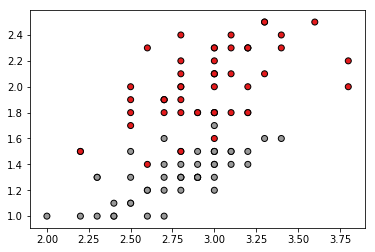

In [25]:
from sklearn import datasets

iris = datasets.load_iris()
selector = iris.target != 0 # ограничемся только двумя классами
X = iris.data[:, [1,3]][selector]  # и двумя переменными
y = iris.target[selector]
y[y==2] = -1 # конвертируем метки классов к 1/-1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')

Первое что нужно сделать - это отнормировать входные данные.
$$
\hat{x_i} = \frac{ x_i - \mu } { \sqrt{\sigma + \epsilon} }
$$

Необходимость нормировки объясняется следующей картинкой:
![image.png](./imgs/9.png)

In [26]:
type(X)


numpy.ndarray

In [9]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std

In [10]:
# добавляем единичную колонку для w0
X = np.hstack([ np.ones((X.shape[0], 1)), X] )

In [11]:
# Инициализируем веса случайны образом
np.random.seed(11)
w = np.random.normal(scale=0.001, size = X.shape[1])

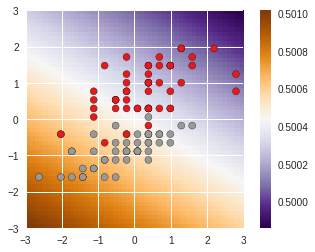

In [12]:
# Функция для отрисовки плотности вероятности
def draw_model(w, rx=3, ry=2, ft=None):
    xx, yy = np.meshgrid(np.linspace(-rx, rx, 50), np.linspace(-rx, rx, 50))
    Z = np.vstack([np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]).T
    if ft is not None:
        Z = ft.fit_transform(Z)
    p = (1. / (1. + np.exp(-np.dot(Z, w)))).reshape(xx.shape)
    plt.imshow(p, cmap=plt.cm.PuOr_r, extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin='lower')
    plt.colorbar()
    
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.Set1, edgecolor='k')
draw_model(w)

Выпишем градиент функции потерь:
$$
    \nabla L = \left\{ - \frac{y_i \vec{x_i} }  { 1 + \exp^{y_i\vec{w}^T\vec{x_i}} } + \lambda \vec{w} \right\} 
$$

Widget Javascript not detected.  It may not be installed or enabled properly.



[-0.32021304  0.78135806 -4.65689231] [ 0.0715739  -0.08041936  0.02099938]


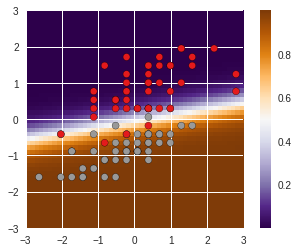

In [13]:
import tqdm

for iter in tqdm.tqdm_notebook(range(100)):
    for i in range(X.shape[0]):
        j = np.random.randint(0, X.shape[0])
        grad = - y[j] * X[j] / \
            ( 1 + math.exp( y[j] * np.dot(w.T, X[j]) ) ) + 0 * w
        w = w - 0.01 * grad
plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.Set1, edgecolor='k')
print(w, grad)
draw_model(w)

# Библиотека sklearn

[[-0.12652673  0.49933727 -3.3849045 ]] [-0.32021304  0.78135806 -4.65689231]


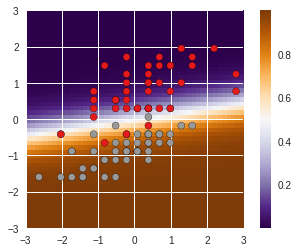

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', max_iter=100)
logreg.fit(X, y)
print(logreg.coef_, w)

plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.Set1, edgecolor='k')
draw_model(logreg.coef_[0])

# Проблема XOR

![image.png](./imgs/10.png)

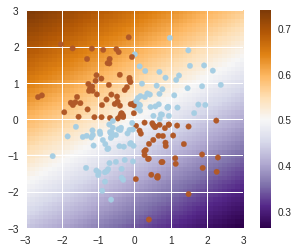

In [15]:
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

X = np.hstack([ np.ones((X.shape[0], 1)), X] ) # добавляем единичную колонку для w0
logreg = LogisticRegression()
logreg.fit(X, y)

draw_model(logreg.coef_[0])

# Решение XOR через полиномиальные признаки

Полиномиальные признаки:
$$
x_1, x_2, x_1x_2, x_1^2, x_2^2,...
$$

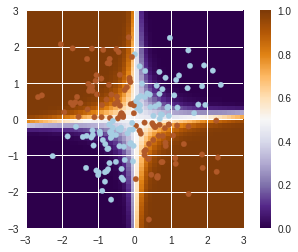

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

ft = PolynomialFeatures(degree=2)
XX = ft.fit_transform(X)
logreg.fit(XX, y)

plt.scatter(X[:, 1], X[:, 2], s=30, c=y, cmap=plt.cm.Paired);
draw_model(logreg.coef_[0], ft=ft)

# Многослойный персептрон - Feature learning (c)

А что, если в качестве преобразователя признаков взять обучаемую модель? Например логистическую регрессию?

![image.png](./imgs/11.png)
$$
y(\vec{x}) = \sigma \left( \sum_i w_i g_i(\vec{x}) \right) \\
g_i(\vec{x}) = \sigma \left( \sum_j w_ij x_j \right)
$$

Можно делать штуки повеселее )

![image.png](./imgs/12.png)

# Универсальная теорема аппроксимации 
### Теорема Цыбенко (1989)

Искусственная нейронная сеть прямой связи (англ. feed-forward; в которых связи не образуют циклов) с одним скрытым слоем может аппроксимировать любую непрерывную функцию многих переменных с любой точностью. Условиями являются: достаточное количество нейронов скрытого слоя и удачный подбор параметров.

http://playground.tensorflow.org/
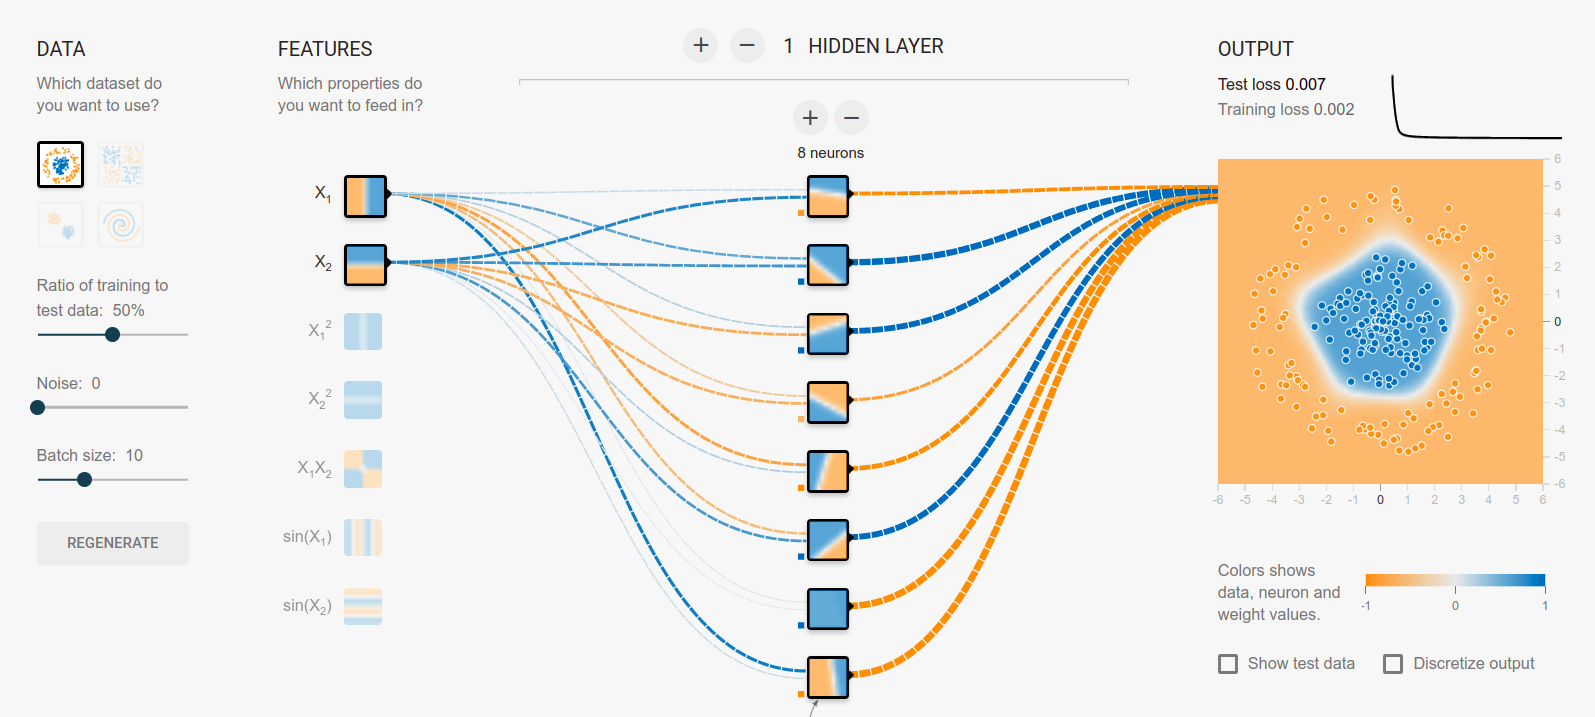

# В следующей серии

Мы поговорим:
- о том, как обучить многослойный персептрон алгоритмом обратного распространения ошибки
- поговорим о затухании и взрыве градиентов
- о видах функции актвации и типах нейронных сетей
- обсудим, наконец, что такое deep learning и насколько он глубок

**Stay tuned!!!**
<img src="./imgs/13.png" alt="" style="width: 200px;"/>

# Чеклист

- модель
- алгоритм обучения
- метрика качества
- обучение с учителем и без
- тренирочный датасет
- модель линейной регрессии
- правдоподобие
- как из правдоподобия получается MSE
- решение оптимизационной задачи линейной регрессии
- переобучение
- регуляризация
- задача классификации, модель логистической регрессии
- вывод logloss через правдоподобие
- оптимизация градиентным спуском
- подготовка данных для градиентного спуска
- проблема XOR
- понятие feature learning
- многослойный персептрон
- синаптические веса, функция активации

# Почитать вечерком

Годный habr:
- хороший обзор библиотек [pandas](https://habrahabr.ru/company/ods/blog/322626/) и [библиотек для визуального анализа](https://habrahabr.ru/company/ods/blog/323210/).
- [Открытый курс машинного обучения. Тема 4. Линейные модели классификации и регрессии](https://habrahabr.ru/company/ods/blog/323890/)
- [Базовые принципы машинного обучения на примере линейной регрессии](https://habrahabr.ru/company/ods/blog/322076/)

Книги:
- Goodfellow et.al., [Deep Learning](http://www.deeplearningbook.org/contents/ml.html), 2016 
- Wang et.al., [On the Origin of Deep Learning](https://arxiv.org/pdf/1702.07800.pdf), 2017
- Hastie et.al., [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf), 2003
- Bishop, [Pattern Recognition and Machine Learning](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf), 2006
